#**Reza Dehkordi**
#**03-07-2021**

# **Overview:**
> As a data scientist for a large winery in Italy I have been given the task of classifing 3 boxes of Italian wine without any indication of their origin. I have been given the task to determaine the wine's origin based on their chemical data. As accuracy is more valued than explainability, I will develope a set of complex ensemble modles to determine the reigen of the region of the wines. The main purpose of ensemble models is to achive accurate results by combining many less powerful classifers together. In this task 14 different models will be tested on the given data:
- 4 baseline (Random Forest, KNN, SVC, Logistic Regression)
- 4 Bagging (Random Forest, KNN, SVC, Logistic Regression)
- 4 Boosting (Ada Boost, Gradient Boost, XG Boost, Ensemble)
- 1 stacked model of a (Random Forest,  kNN,  SVC, Logistic Regression - - input into a Logistic Regression meta-classifier) using class labels
- 1 stacked model  w/ Grid Search Cross Validation hyperparameters (using any combination of models)

# **Data:**
> Data imported from the python sklearn libarary under the datasets module

### **Load In Packages**

In [ ]:
#conda install -c conda-forge xgboost
#conda install -c conda-forge mlxtend
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from mlxtend.classifier import StackingClassifier
from mlxtend.classifier import StackingCVClassifier
from mlxtend.classifier import EnsembleVoteClassifier

from xgboost import XGBClassifier



/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


### **Load Dataset and Convert to Pandas DataFrame**

In [ ]:
wine = load_wine()
# Convert to Pandas Dataframe
wine_dataframe = pd.DataFrame(data = np.c_[wine['data'], wine['target']], 
                             columns = wine['feature_names'] + ['target'])
print(wine.DESCR)


.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            1

# **EDA:**

In [ ]:
np.shape(wine_dataframe)

(178, 14)

Data: 178 * 13

Labels: 178 * 1

In [ ]:
wine_dataframe.isnull().values.all()

False

No Null values in the dataframe.

In [ ]:
wine_dataframe.head()


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0


In [ ]:
wine_dataframe.round(4).describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


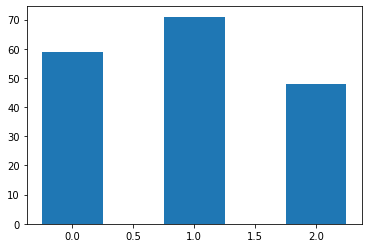

In [ ]:
sum0 = np.sum(wine_dataframe.target == 0)
sum1 = np.sum(wine_dataframe.target == 1)
sum2 = np.sum(wine_dataframe.target == 2)
labels = [0,1,2]
sums = [sum0, sum1, sum2]
plt.bar(labels, sums, width=0.5)
plt.show()

Distribution of the lables

# **Models:**

### **1. Base Models:**

In [ ]:
# Code Taken From 
# https://medium.com/@saugata.paul1010/ensemble-learning-bagging-boosting-stacking-and-cascading-classifiers-in-machine-learning-9c66cb271674

X = wine_dataframe.drop("target", 1)
y = wine_dataframe.target

RANDOM_SEED = 4061

#Base Learners
rf_clf = RandomForestClassifier(n_estimators=10, random_state=RANDOM_SEED)
knn_clf = KNeighborsClassifier(n_neighbors=2)
svc_clf = SVC(C=10000.0, kernel='rbf', random_state=RANDOM_SEED)
lr_clf = LogisticRegression(C=20000, penalty='l2', random_state=RANDOM_SEED)

classifier_array = [rf_clf, knn_clf, svc_clf, lr_clf]
labels = [clf.__class__.__name__ for clf in classifier_array]

normal_accuracy = []
normal_std = []

for clf in classifier_array:
    cv_scores = cross_val_score(clf, X, y, cv=3, n_jobs=-1)
    
    normal_accuracy.append(np.round(cv_scores.mean(),4))
    normal_std.append(np.round(cv_scores.std(),4))
    
    print("Accuracy: %0.4f (+/- %0.4f) [Normal %s]" % (cv_scores.mean(), cv_scores.std(), clf.__class__.__name__))



Accuracy: 0.9213 (+/- 0.0424) [Normal RandomForestClassifier]
Accuracy: 0.6465 (+/- 0.0662) [Normal KNeighborsClassifier]
Accuracy: 0.9273 (+/- 0.0476) [Normal SVC]
Accuracy: 0.9108 (+/- 0.0925) [Normal LogisticRegression]


Performance: 
> 

### **2. Bagging:**

In [ ]:
bagging_accuracy = []
bagging_std = []

for clf in classifier_array:
    bagging_clf = BaggingClassifier(clf, max_samples=0.4, max_features=3, random_state=RANDOM_SEED)
    bagging_scores = cross_val_score(bagging_clf, X, y, cv=3, n_jobs=-1)

    print("Accuracy: %0.4f (+/- %0.4f) [Bagging %s]" % (bagging_scores.mean(), bagging_scores.std(), clf.__class__.__name__))


Accuracy: 0.9440 (+/- 0.0205) [Bagging RandomForestClassifier]
Accuracy: 0.9215 (+/- 0.0442) [Bagging KNeighborsClassifier]
Accuracy: 0.9441 (+/- 0.0417) [Bagging SVC]
Accuracy: 0.9328 (+/- 0.0270) [Bagging LogisticRegression]


Performace:


### **3. Boosting:**

In [ ]:
boost_accuracies = []
ada_boost = AdaBoostClassifier(n_estimators=5)
gradient_boost = GradientBoostingClassifier(n_estimators=10)
xgb_boost = XGBClassifier(max_depth=5, learning_rate=0.001)

ensemble_clf = EnsembleVoteClassifier(clfs=[ada_boost, gradient_boost, xgb_boost], voting='hard')
boosting_labels = ['Ada Boost', 'Gradient Boost', 'XG Boost', 'Ensemble']

for clf, label in zip([ada_boost, gradient_boost, xgb_boost, ensemble_clf], boosting_labels):
  boosting_scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
  print("Accuracy: %0.4f (+/- %0.4f) [Boosting %s]" % (boosting_scores.mean(), boosting_scores.std(), clf.__class__.__name__))


Accuracy: 0.8427 (+/- 0.0350) [Boosting AdaBoostClassifier]
Accuracy: 0.8479 (+/- 0.0639) [Boosting GradientBoostingClassifier]
Accuracy: 0.8707 (+/- 0.0698) [Boosting XGBClassifier]
Accuracy: 0.8762 (+/- 0.0563) [Boosting EnsembleVoteClassifier]


Performance:

### **4. Stacked Model of a (RF, KNN, SVC, LR input into a LR meta-classifier):**

In [ ]:
stacked_clf = StackingClassifier(classifiers=classifier_array, meta_classifier=lr_clf)

for clf, label in zip(classifier_array, labels):
  stacked_scores = model_selection.cross_val_score(clf, X, y, cv=3, scoring="accuracy")
  print("Accuracy: %0.4f (+/- %0.4f) [Stacking %s]" % (stacked_scores.mean(), stacked_scores.std(), clf.__class__.__name__)) 

Accuracy: 0.9213 (+/- 0.0424) [Stacking RandomForestClassifier]
Accuracy: 0.6465 (+/- 0.0662) [Stacking KNeighborsClassifier]
Accuracy: 0.9273 (+/- 0.0476) [Stacking SVC]
Accuracy: 0.9108 (+/- 0.0925) [Stacking LogisticRegression]


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Performace:

### **5. Stacked Model with Grid Search Closs Validation Hyperprameters(using....):**

In [ ]:
"""
params = {'random_forest_classifier__n_estimators': np.arange(10,20), 
          'random_forest_classifier__max_depth': np.arange(1,5), 
          'k_nearest_neighbors_classifier__n_neighbors': np.arange(1,20,2),
          'meta_logistic_regression_C': [0.001,0.01,0.1,1,10,100]}

grid_search_cv = GridSearchCV(estimator=stacked_clf, param_grid=params, cv=5, refit=True)
grid_search_cv.fit(X, y)

for param in grid_search_cv.get_params().keys():
  print(param)

cv_keys = ('mean_test_score', 'std_test_score', 'params')
print('Best parameters: %s' % grid_search_cv.best_params_)
print('Accuracy: %.2f' % grid_search_cv.best_score_)
"""
params = {'randomforestclassifier__n_estimators': np.arange(10,20), 
          'randomforestclassifier__max_depth': np.arange(1,5), 
          'kneighborsclassifier__n_neighbors': np.arange(1,20,2),
          'svc__C': [0.001,0.01,0.1,1,10,100]}

gsearch_cv = GridSearchCV(estimator=stacked_clf, param_grid=params, cv=5, refit=True)
gsearch_cv.fit(X, y)

cv_keys = ('mean_test_score', 'std_test_score', 'params')
print('Best parameters: %s' % gsearch_cv.best_params_)
print('Accuracy: %.2f' % gsearch_cv.best_score_)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


KeyboardInterrupt: ignored